## Introduction to our first task: 'Where is He pointing?'

Description about the dataset.

We're going to try to create a model to enter the Dogs vs Cats competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): "State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". So if we can beat 80%, then we will be at the cutting edge as of 2013!

In [1]:
# These are used to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need.

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to our data. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly.

In [4]:
PATH = "data/gesture/"
sz=224
metrics = []

For the fastai library, the programming framework used to behind the scenes to work with NVidia GPUs is CUDA. Following line checks for CUDA availability.

In [5]:
torch.cuda.is_available()

True

Also, NVidia provides special accelerated functions for deep learning in a package called CuDNN.

In [6]:
torch.backends.cudnn.enabled

True

## First look at Dataset pictures

The dataset has *train* and *test* directories. Also each dir has have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [7]:
os.listdir(PATH)

['test', 'valid', 'models', 'train', 'tmp']

In [8]:
os.listdir(f'{PATH}valid')

['bottom-right', 'top-right', 'inaction', 'bottom-left', 'top-left']

In [9]:
files_tl = os.listdir(f'{PATH}valid/top-left')[:5]
files_bl = os.listdir(f'{PATH}valid/bottom-left')[:5]
files_tl

['frame543.jpg',
 'frame671.jpg',
 'frame458.jpg',
 'frame560.jpg',
 'frame550.jpg']

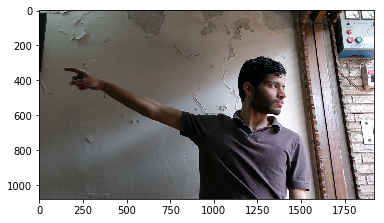

In [10]:
img = plt.imread(f'{PATH}valid/top-left/{files_tl[0]}')
plt.imshow(img);

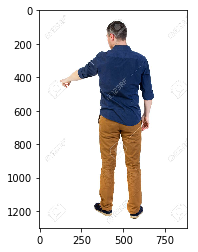

In [11]:
img = plt.imread(f'{PATH}valid/bottom-left/{files_bl[1]}')
plt.imshow(img);

Here is how the raw data looks like

In [12]:
# img.shape

In [13]:
# img[:4,:4]

## Data exploration

Let's see the image sizes histogram.

In [12]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, bs=64, test_name='test', tfms=tfms_from_model(arch, sz))

In [13]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [14]:
row_sz, col_sz = list(zip(*size_d.values()))

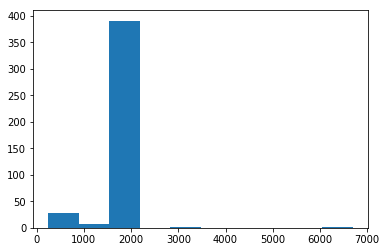

In [15]:
plt.hist(row_sz);

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Some more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks).

In [13]:
# Uncomment line below to reset the precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [16]:
# learn = ConvLearner.pretrained(arch, data, precompute=True)
# learn.fit(1e-2, 7) # bs=64

__What do we see from above ? What happens after 3 epochs ?__

In [17]:
# learn = ConvLearner.pretrained(arch, data, precompute=True)
# learn.fit(1e-2, 3)

__What does 95.31% mean in terms of accuracy of model ?__

In [18]:
# learn.save('cap_simple')

In [ ]:
# learn.load('cap_simple')

In [40]:
# learn.save('34_gesture')

In [22]:
# learn.load('34_gesture')

## personal testing

In [19]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, bs=64, tfms=tfms_from_model(arch, sz), test_name='test')

In [20]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy               
    0      1.264507   0.458512   0.914931  
    1      0.741207   0.219737   0.947917        
    2      0.576048   0.239951   0.947917        



[0.23995097, 0.9479166666666666]

__validation accuracy__

In [21]:
log_preds = learn.predict()

In [22]:
probs = np.exp(log_preds)

__before__ unfreeze

In [23]:
accuracy_np(probs, data.val_y)

0.9285714285714286

__after__ unfreeze

In [24]:
# accuracy_np(probs, data.val_y)

__test set accuracy__

In [25]:
test_fnames = []
for file in data.test_ds.fnames:
    test_fnames.append(int(file[5:-4]))

In [26]:
test_val = []
for file in test_fnames:
    if file <= 3:
        test_val.append(0)
    elif file <= 5:
        test_val.append(1)
    elif file <= 29:
        test_val.append(2)
    elif file <= 87:
        test_val.append(3)
    else:
        test_val.append(4)
        
test_val = np.array(test_val)

In [27]:
log_preds_test = learn.predict(is_test=True)
probs_test = np.exp(log_preds_test)

before unfreeze

In [28]:
accuracy_np(probs_test, test_val)

0.95

after unfreeze

In [29]:
# accuracy_np(probs_test, test_val)

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [20]:
data.val_y.shape

(140,)

In [21]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4])

In [22]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['bottom-left', 'bottom-right', 'inaction', 'top-left', 'top-right']

In [19]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()

In [71]:
log_preds[:4]

array([[-2.6532 , -3.17069, -3.30419, -0.326  , -2.04743],
       [-2.98102, -2.37268, -3.50277, -0.5397 , -1.41472],
       [-4.47234, -3.10383, -4.7142 , -3.95267, -0.08825],
       [-4.97678, -0.07871, -2.79854, -9.21377, -4.85364]], dtype=float32)

In [20]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds)
print(probs[:4])
print(preds[:4])

[[0.21115 0.01294 0.16813 0.03649 0.57129]
 [0.3535  0.10853 0.17227 0.14246 0.22324]
 [0.17288 0.03094 0.33758 0.04992 0.40868]
 [0.27611 0.02856 0.08816 0.00351 0.60367]]
[4 0 4 4]


In [73]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 6, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [74]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [75]:
def title_maker(idx):
#   predicted label and actual label
    ttl = 'real: ' + data.classes[data.val_y[idx]] + ' (' + str(probs[idx, data.val_y[idx]]) + ')'
    ttl = ttl + '\npred: ' + data.classes[preds[idx]] + ' (' + str(probs[idx, preds[idx]]) + ')'
    return ttl

In [76]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title, rows=1):
    if len(idxs) == 0: 
        print('No image found') 
        return None
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [title_maker(x) for x in idxs]
    print(title)
    return plots(imgs, rows=rows, titles=title_probs, figsize=(16,8))

Correctly classified


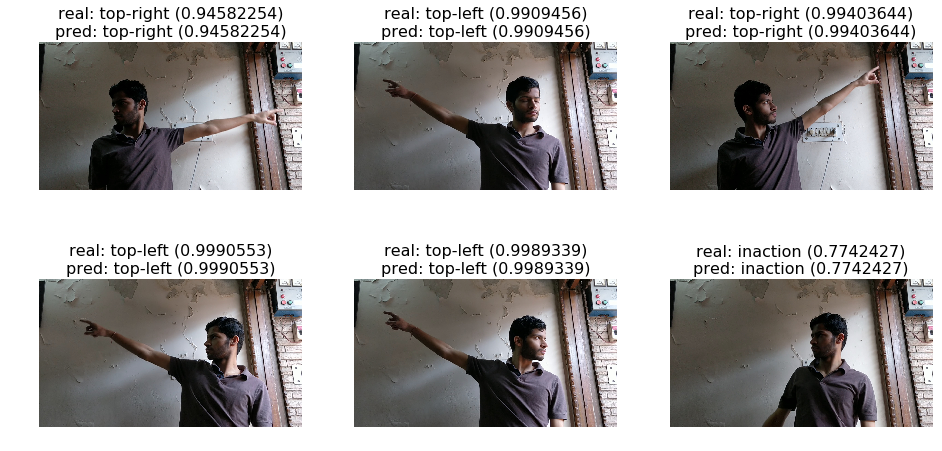

In [77]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified", rows=2)

Incorrectly classified


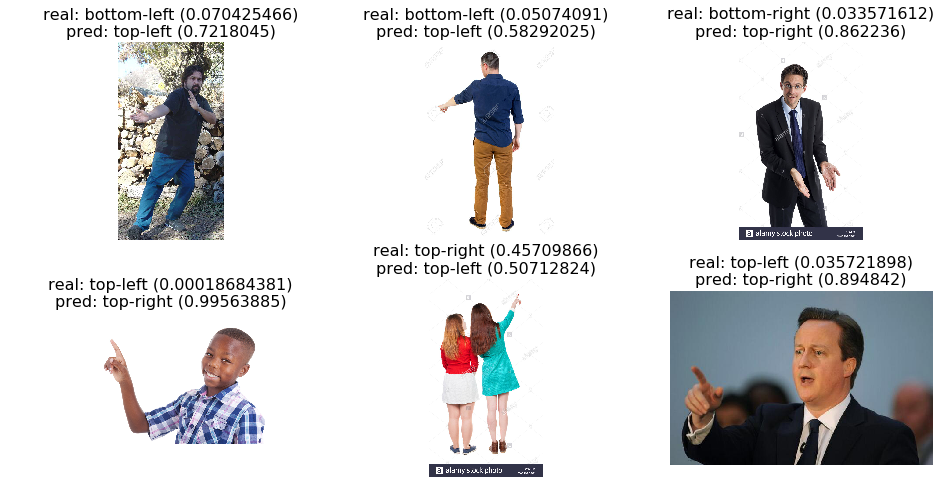

In [78]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified", rows=2)

In [79]:
def most_by_mask(mask, mult, y):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs, y])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    mask = ((preds == data.val_y)==is_correct) & (data.val_y == y)
    return most_by_mask(mask, mult, y)

In [80]:
data.classes

['bottom-left', 'bottom-right', 'inaction', 'top-left', 'top-right']

Most correct top-left


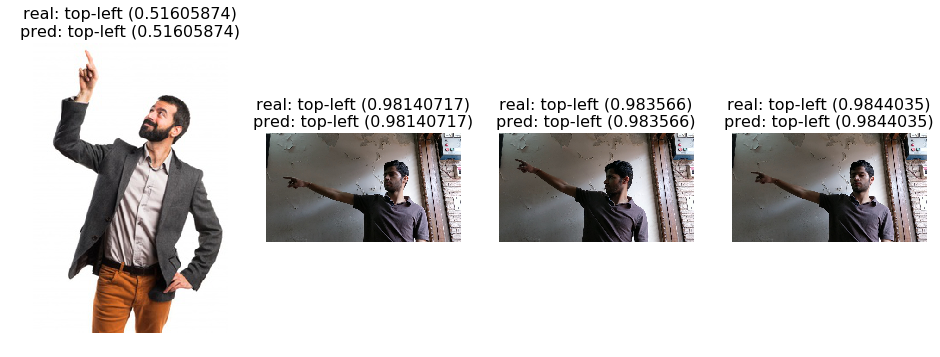

In [81]:
plot_val_with_title(most_by_correct(3, True), "Most correct top-left")

Most correct top-right


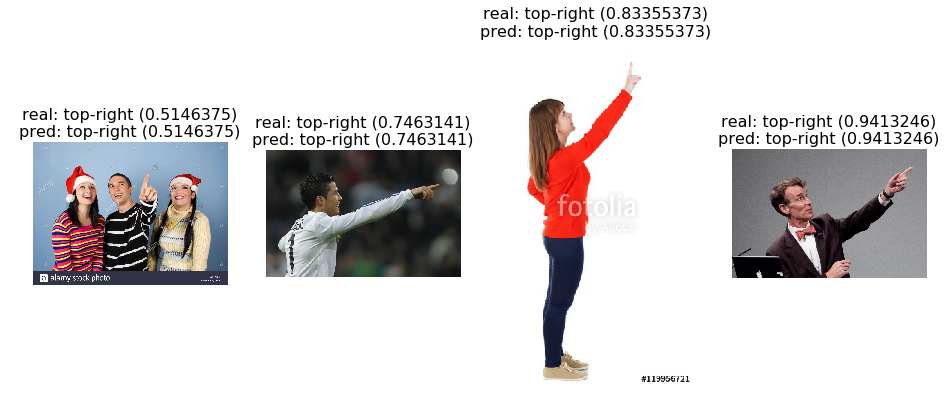

In [82]:
plot_val_with_title(most_by_correct(4, True), "Most correct top-right")

Most correct inaction


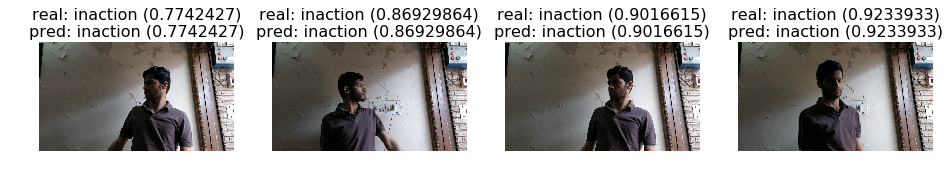

In [83]:
plot_val_with_title(most_by_correct(2, True), "Most correct inaction")

In [84]:
plot_val_with_title(most_by_correct(0, True), "Most correct bottom-left")

No image found


Most correct bottom-right


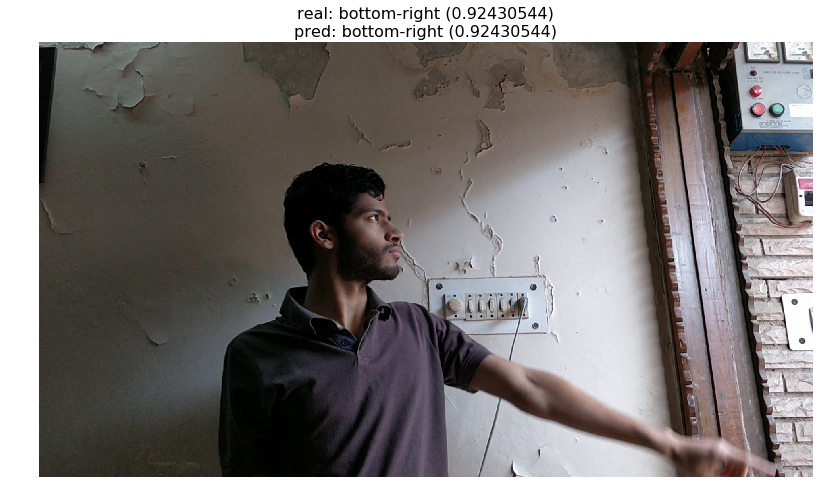

In [85]:
plot_val_with_title(most_by_correct(1, True), "Most correct bottom-right")

Most incorrect top-left


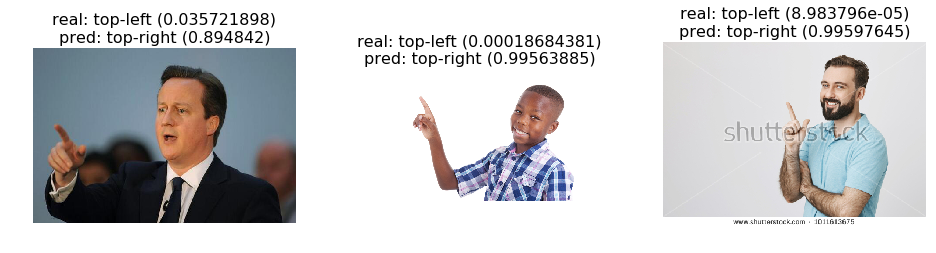

In [86]:
plot_val_with_title(most_by_correct(3, False), "Most incorrect top-left")

Most incorrect top-right


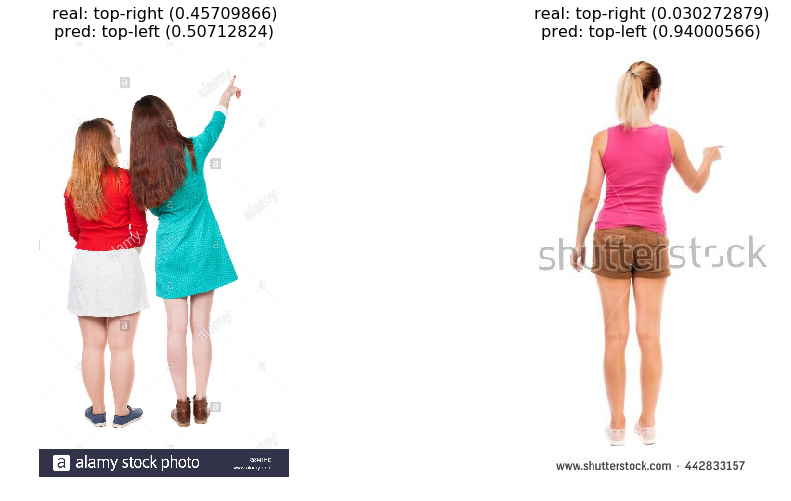

In [87]:
plot_val_with_title(most_by_correct(4, False), "Most incorrect top-right")

In [41]:
plot_val_with_title(most_by_correct(2, False), "Most incorrect inaction")

No image found


Most incorrect bottom-left


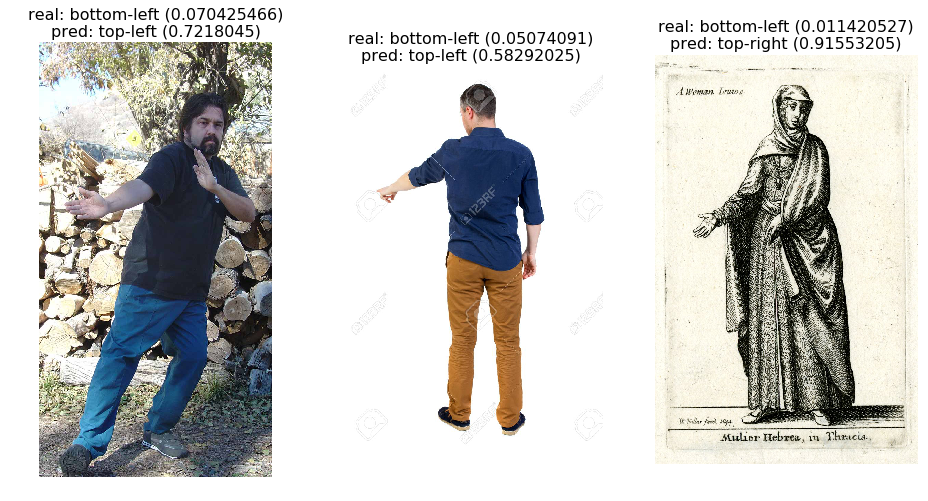

In [88]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect bottom-left")

Most incorrect bottom-right


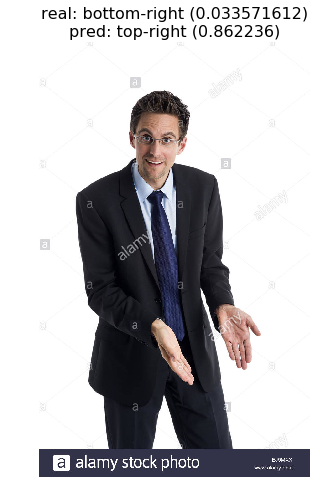

In [89]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect bottom-right")

## Refining

### Learning Rate Finder

The *learning rate* determines how quickly or how slowly we want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss starts decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [34]:
# change batch size to 16 if no graph
data = ImageClassifierData.from_paths(PATH, bs=8, tfms=tfms_from_model(arch, sz))

In [35]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [36]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 37%|███▋      | 20/54 [00:00<00:00, 119.50it/s, loss=7.15]


The `learn` object contains an attribute `sched` that contains the learning rate scheduler, and has some convenient plotting functionality.

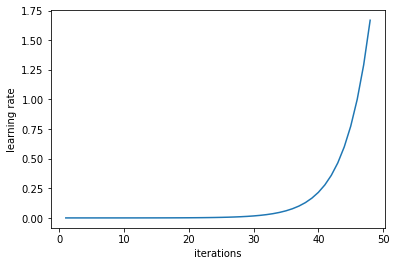

In [37]:
learn.sched.plot_lr()

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

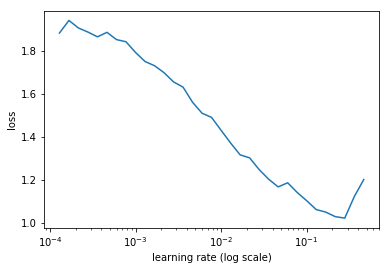

In [38]:
learn.sched.plot() # at bs=8

The loss is still clearly improving at ____________ lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

### Data Augmentation

Do data aug, new model, train see results.

In [92]:
arch = resnet34
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_basic, max_zoom=1.1)

In [93]:
PATH

'data/gesture/'

In [94]:
data = ImageClassifierData.from_paths(PATH, bs=64, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [95]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.995723   0.50727    0.925347  



[0.5072703, 0.9253472288449606]

by default layers are frozen

In [96]:
learn.precompute=False

In [97]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.734474   0.302779   0.925347  
    1      0.623501   0.230038   0.947917                
    2      0.521525   0.236557   0.942708                



[0.2365567, 0.9427083333333334]

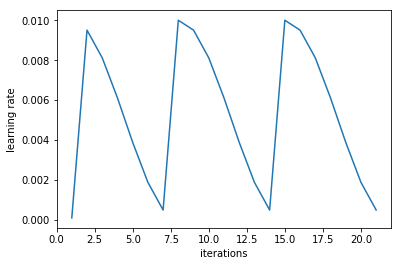

In [98]:
learn.sched.plot_lr()

In [99]:
learn.save('cap_lastlayer')

In [ ]:
# learn.load('cap_lastlayer')

### Unfreezing

this is done after model has been trained once.

unfreeze and differential learning rates. 

In [36]:
learn.unfreeze()

In [37]:
# lr=np.array([1e-4,1e-3,1e-2]) # original
lr=np.array([1e-5,1e-4,1e-3])

In [38]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      0.116302   0.239388   0.953125  
    1      0.117911   0.247057   0.953125                
    2      0.113611   0.251742   0.953125                



[0.25174198, 0.953125]

In [46]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      0.087956   0.25352    0.953125  
    1      0.096677   0.255356   0.953125                 
    2      0.091369   0.255513   0.942708                 



[0.25551343, 0.9427083333333334]

In [54]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      0.086795   0.25776    0.947917  
    1      0.083869   0.254006   0.9375                   
    2      0.08267    0.259174   0.9375                   



[0.2591744, 0.9375]

In [35]:
# learn.fit(lr, 3, cycle_len=1, cycle_mult=2)       # old way: overfits

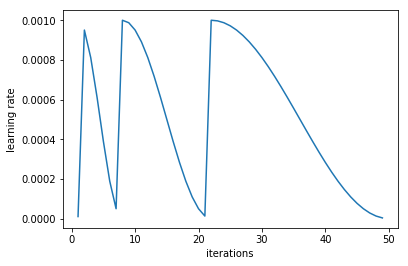

In [123]:
learn.sched.plot_lr()

In [104]:
learn.save('cap_all')

In [9]:
# learn.load('cap_all')

### Test time augmentation

Using data augmentation at *inference* time (also known as *test* time). This is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in our validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we use the learner object's `TTA()` method.

In [124]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [50]:
# what is log_preds, probs, or accuracy_np. 

# print(log_preds)
# print(probs)
# print(accuracy_np)

# why werent these calculated before, just for normal model.

In [51]:
??accuracy_np

In [116]:
accuracy_np(probs, y) # bs=64 simple

0.9428571428571428

In [125]:
accuracy_np(probs, y) # bs=64 simple + unfreeze

0.9357142857142857

In [ ]:
accuracy_np(probs, y) # bs=8  with unfreeze

In [106]:
accuracy_np(probs, y) # bs=64 with unfreeze

0.9214285714285714

In [64]:
accuracy_np(probs, y) # bs=16 with unfreeze

0.9285714285714286

In [52]:
accuracy_np(probs, y) # without unfreeze

0.9071428571428571

Generally a 10-20% reduction in error could be seen depending upon the dataset when using TTA at this point.

## Analysing Results

### Confusion Matrix

We will analyze the result of this classification model using a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use:

In [117]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [118]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 0  0  0  0  3]
 [ 0  1  0  0  1]
 [ 0  0 24  0  0]
 [ 0  0  0 55  3]
 [ 0  0  0  1 52]]


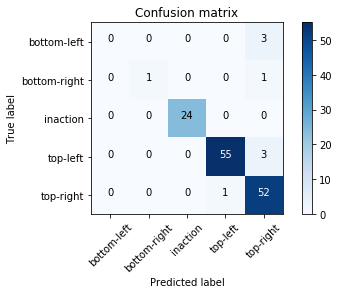

In [119]:
plot_confusion_matrix(cm, data.classes) # simple

[[ 0  0  0  2  1]
 [ 0  1  0  0  1]
 [ 0  0 24  0  0]
 [ 0  0  0 54  4]
 [ 0  0  0  3 50]]


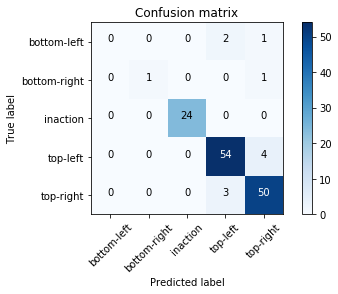

In [109]:
plot_confusion_matrix(cm, data.classes) # bs=64

[[ 0  0  0  2  1]
 [ 0  1  0  0  1]
 [ 0  0 23  1  0]
 [ 0  0  0 55  3]
 [ 0  1  0  4 48]]


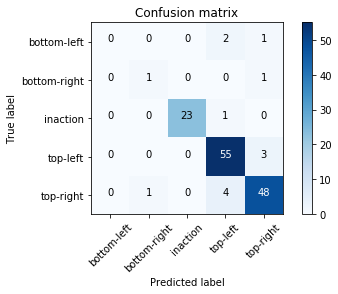

In [55]:
plot_confusion_matrix(cm, data.classes)

## Choosing a learning rate

### Change batch size run learning rate finder

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss starts decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [95]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [96]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy       
    0      1.398532   2.967447   0.932292  



Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

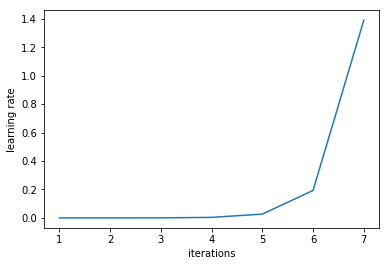

In [97]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

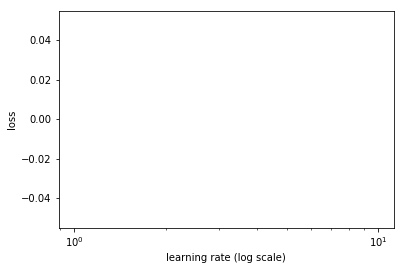

In [98]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

## Improving our model

### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizaing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [23]:
arch = resnet34

In [19]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [47]:
def get_augs(n=1):
    
    #     data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
    
    x,_ = next(iter(data.aug_dl))
    
    return data.trn_ds.denorm(x)[n]

In [46]:
PATH

'data/gesture/'

In [5]:
# plots(np.stack([get_augs(2)]))

In [1]:
# ims = np.stack([get_augs() for i in range(6)])

In [2]:
# plots(ims, rows=2)

In [3]:
# ims = np.stack([get_augs() for i in range(6)])

In [4]:
# plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [11]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [12]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.0462   0.02459  0.99121]                         



In [13]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [14]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.05     0.02535  0.9917 ]                         
[ 1.       0.04248  0.02372  0.99219]                         
[ 2.       0.04918  0.02365  0.9917 ]                         



In [8]:
# learn.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [15]:
# learn.save('224_lastlayer')

In [ ]:
# learn.load('224_lastlayer')

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [16]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [37]:
lr=np.array([1e-4,1e-3,1e-2])

In [38]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy         
    0      0.041655   0.278734   0.9375    
    1      0.112186   0.2802     0.9375           
    2      0.139315   0.282519   0.9375           
    3      0.108214   0.277136   0.9375          
    4      0.101107   0.277374   0.9375           
    5      0.099442   0.279542   0.9375           
    6      0.089935   0.277958   0.9375           



[0.27795762, 0.9375]

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

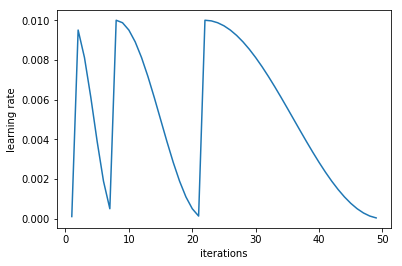

In [39]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [19]:
learn.save('224_all')

In [9]:
learn.load('224_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [28]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [20]:
accuracy_np(probs, y)

0.991

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!